In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [3]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

Untar the data at location `URLS.PETS` and save the path to the variable `path`.

In [5]:
path = untar_data(URLs.PETS); path

PosixPath('/home/paperspace/.fastai/data/oxford-iiit-pet')

Show the contents at `path`.

In [6]:
path.ls()

[PosixPath('/home/paperspace/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/home/paperspace/.fastai/data/oxford-iiit-pet/annotations')]

Create `Path` objects at `path/'annotations'` and `path/'images'`.

In [7]:
path_anno = path/'annotations'
path_img = path/'images'

Get all of the image file names from `path_img`. Print the first five.

In [8]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/home/paperspace/.fastai/data/oxford-iiit-pet/images/Bombay_70.jpg'),
 PosixPath('/home/paperspace/.fastai/data/oxford-iiit-pet/images/pug_169.jpg'),
 PosixPath('/home/paperspace/.fastai/data/oxford-iiit-pet/images/Ragdoll_96.jpg'),
 PosixPath('/home/paperspace/.fastai/data/oxford-iiit-pet/images/boxer_43.jpg'),
 PosixPath('/home/paperspace/.fastai/data/oxford-iiit-pet/images/scottish_terrier_4.jpg')]

In [9]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

Get a `ImageDataBunch` object using regex on the filenames from the data in `path_img`. Save it to a variable called `data`. Call `normalize(imagenet_stats)` on this object to ensure that it's properly normalized.

In [10]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

Show a batch of data over 3 rows, with figsize (7,6).

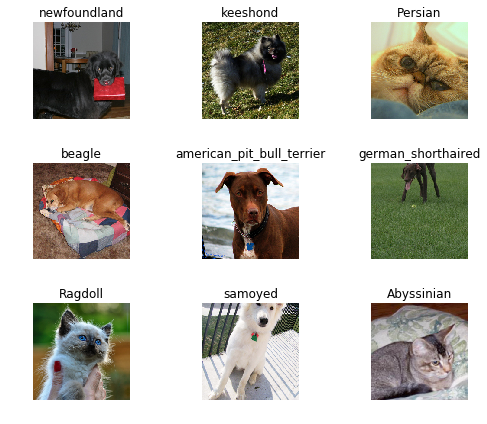

In [ ]:
data.show_batch(rows=3, figsize=(7,6))

Print the data classes and the number of data classes.

In [11]:
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

## Training: resnet34

Create a ResNet34 CNN learner object. Your metric should be `error_rate`. 

In [12]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

Print out the contents of the learner.

In [13]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

Fit the learner for a cycle consisting of four epochs. Try to get below 0.07 error.

In [14]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,1.385065,0.319304,0.098782
2,0.559753,0.234884,0.075778
3,0.348994,0.211086,0.069689
4,0.254078,0.207886,0.071042


Save your learner to 'stage-1'.

In [15]:
learn.save('stage-1')

## Results

In [16]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

In [17]:
doc(ClassificationInterpretation.top_losses)

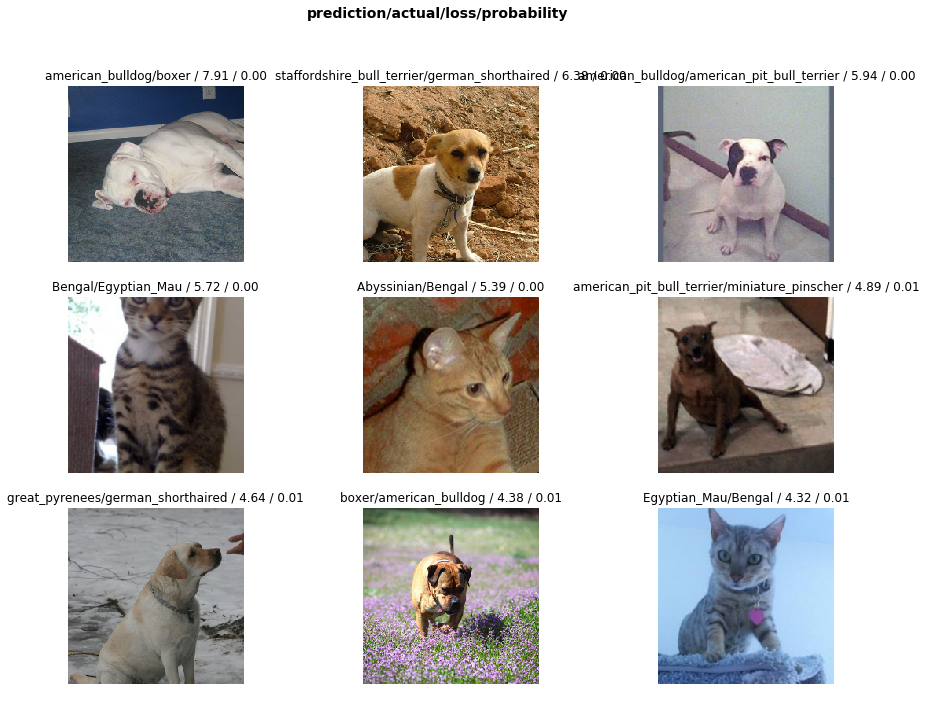

In [18]:
interp.plot_top_losses(9, figsize=(15,11))

In [19]:
doc(interp.plot_top_losses)

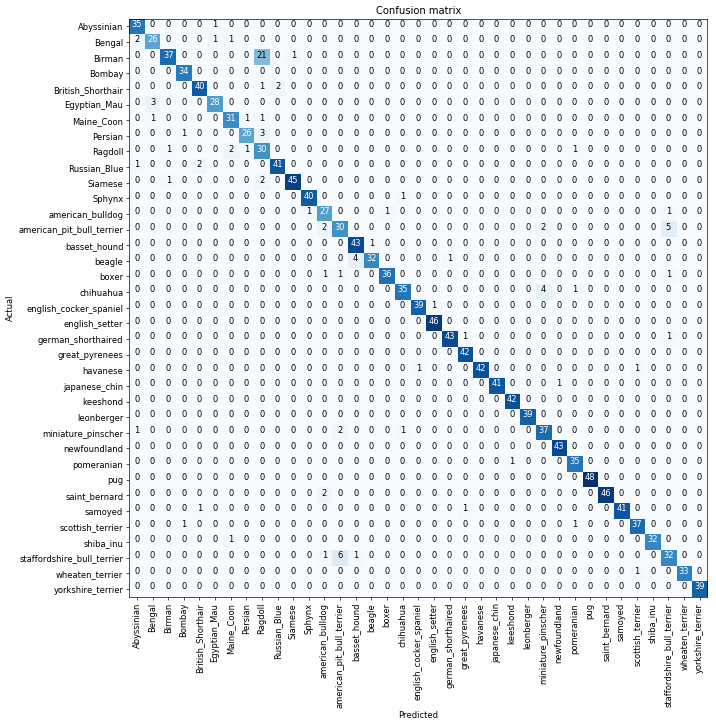

In [20]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [22]:
doc(interp.most_confused)

In [21]:
interp.most_confused(min_val=2)

[('Birman', 'Ragdoll', 21),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 6),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 5),
 ('beagle', 'basset_hound', 4),
 ('chihuahua', 'miniature_pinscher', 4),
 ('Egyptian_Mau', 'Bengal', 3),
 ('Persian', 'Ragdoll', 3)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [23]:
learn.unfreeze()

In [24]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,0.542931,0.313622,0.106901


In [25]:
learn.load('stage-1');

In [26]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


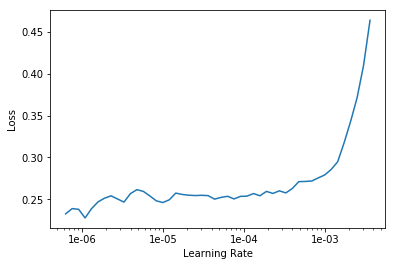

In [27]:
learn.recorder.plot()

In [28]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.244058,0.194245,0.064953
2,0.219058,0.189708,0.062246


That's a pretty accurate model!

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [32]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [33]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


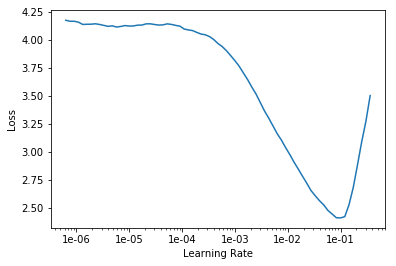

In [34]:
learn.lr_find()
learn.recorder.plot()

In [36]:
doc(learn.fit_one_cycle)

In [37]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate
1,0.744377,0.270223,0.079838
2,0.440831,0.233351,0.077131
3,0.330420,0.191502,0.062923
4,0.267286,0.176855,0.053451
5,0.192027,0.178841,0.050744
6,0.141483,0.139195,0.041272
7,0.113011,0.142080,0.041272
8,0.099226,0.138883,0.041949


In [38]:
learn.save('stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [39]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.087816,0.138356,0.041949
2,0.091311,0.137667,0.042625
3,0.074406,0.135498,0.043978


If it doesn't, you can always go back to your previous model.

In [40]:
learn.load('stage-1-50');

In [41]:
interp = ClassificationInterpretation.from_learner(learn)

In [42]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 8),
 ('american_bulldog', 'american_pit_bull_terrier', 3),
 ('chihuahua', 'miniature_pinscher', 3)]

## Other data formats

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE); path

PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample')

In [ ]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

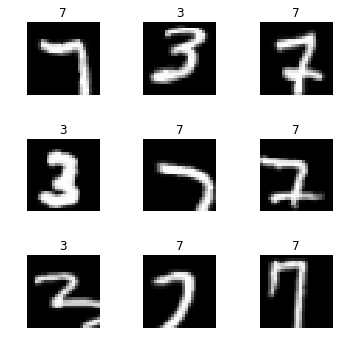

In [ ]:
data.show_batch(rows=3, figsize=(5,5))

In [ ]:
learn = create_cnn(data, models.resnet18, metrics=accuracy)
learn.fit(2)

Total time: 00:23
epoch  train_loss  valid_loss  accuracy
1      0.116117    0.029745    0.991168  (00:12)
2      0.056860    0.015974    0.994603  (00:10)



In [ ]:
df = pd.read_csv(path/'labels.csv')
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


In [ ]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

[0, 1]

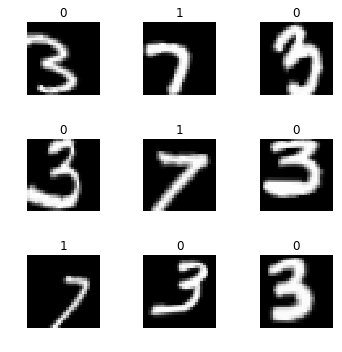

In [ ]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [ ]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

[0, 1]

In [ ]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

[PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample/train/3/7463.png'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample/train/3/21102.png')]

In [ ]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

['3', '7']

In [ ]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

['3', '7']

In [ ]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['3', '3', '3', '3', '3']

In [ ]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

['3', '7']